In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# import seaborn as sns

from gglm.glm.wglmpt import WGLM
from gglm.cnncritic import CNNCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
npz = np.load('./fr_mismatch.npz')
t, stim, mask_spikes_te, u_spk_mean_te, mask_spikes_fr, u_spk_mean_fr  = npz['t'], npz['stim'], npz['mask_spikes_te'], npz['u_spk_mean_te'], npz['mask_spikes_fr'], npz['u_spk_mean_fr']
u_te, u_fr = npz['u_te'], npz['u_fr']
r_te, r_fr = npz['r_te'], npz['r_fr']
u0_ml, eta_vals_ml = npz['glm_u0'], npz['glm_eta']

n_batch_te = mask_spikes_te.shape[1]
n_batch_fr = mask_spikes_fr.shape[1]
mask_spikes = np.concatenate((mask_spikes_te, mask_spikes_fr), axis=1)
n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
mask_spikes_te = torch.from_numpy(mask_spikes_te)
mask_spikes = torch.from_numpy(mask_spikes)
# y = np.concatenate((np.ones(mask_spikes_te.shape[1]), np.zeros(mask_spikes_fr.shape[1])))
y = torch.cat((torch.ones(n_batch_te), torch.zeros(n_batch_fr)))
u = torch.from_numpy(np.concatenate((u_te, u_fr), axis=1))
r = torch.from_numpy(np.concatenate((r_te, r_fr), axis=1))

ms = 1

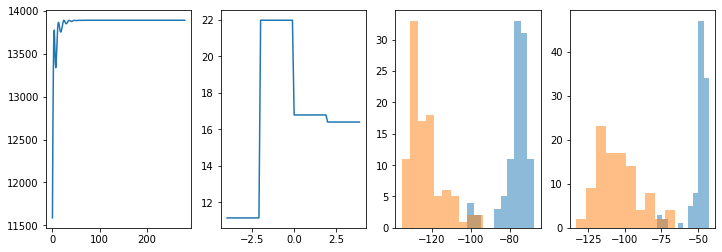

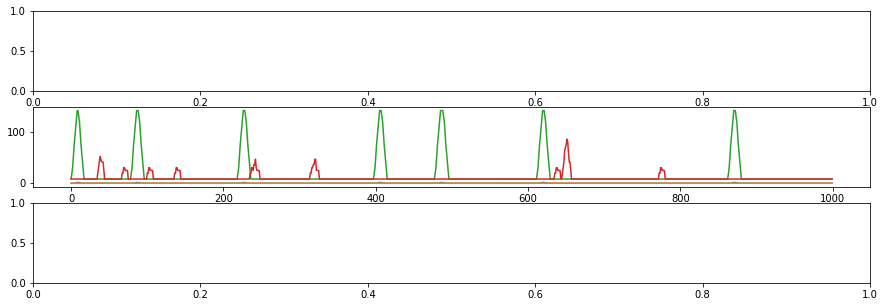

In [3]:
lam_w, num_epochs, lr_g, lr_c, clip = 2.5e2, 120, 2e-2, 1e0, 1e1 # normalized

critic = CNNCritic(n=mask_spikes.shape[0], kernel_size=21, clip=clip)

output0 = critic(x)
output0 = output0.detach().numpy()

neg_w_distance = critic.train(t, mask_spikes, u, r, y, lam_w, lr=lr_c, num_epochs=20)
# w_distance = critic.train(t, mask_spikes, u, r, y, lam_w, lr=lr_c, num_epochs=800)
# w_distance = -np.array(w_distance)
# a_new = critic.transform(t, mask_spikes, u, r).detach().numpy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 4), ncols=4)
ax1.plot(w_distance)
ti = np.arange(tbins[0], tbins[-1], .1)
vals = critic.r_kernel.interpolate(ti)
ax2.plot(ti, vals)
ax3.hist(a0[y == 1], alpha=0.5)
ax3.hist(a0[y == 0], alpha=0.5)
ax4.hist(a_new[y == 1], alpha=0.5)
ax4.hist(a_new[y == 0], alpha=0.5)

b = torch.einsum('tka,a->tk', critic.X_r_spk, critic.theta[0:critic.X_r_spk.shape[2]]).detach().numpy()
b_te = b[:, y == 1]
b_fr = b[:, y == 0]

critic.get_conv_r_spikes(t, mask_spikes)

# critic_conv = critic.r_kernel.convolve_continuous(t, shift_array(mask_spikes, 1, fill_value=False))
critic_conv = torch.einsum('tka,a->tk', critic.X_r_spk, critic.theta[0:critic.X_r_spk.shape[2]]).detach().numpy()
critic_conv_te = critic_conv[:, :n_batch_te]
critic_conv_fr = critic_conv[:, n_batch_te:]

a = critic.transform(t, mask_spikes, u, r)
a_te = a[:n_batch_te]
a_fr = a[n_batch_te:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), nrows=3)
# ax1.plot(u_te[:, 0])
# ax1.plot(u_fr[:, 0])
# ax1.plot(a_te[:, 0] / np.max(np.abs(a_te[:, 0])))
# ax1.plot(a_fr[:, 0] / np.max(np.abs(a_fr[:, 0])))
# ax2.plot((a_te * r_te)[:, 0])
# ax2.plot((a_fr * r_fr)[:, 0])
ax2.plot(t, r_te[:, 0])
ax2.plot(t, r_fr[:, 0])
ax2.plot(t, critic_conv_te[:, 0])
ax2.plot(t, critic_conv_fr[:, 0])

In [9]:
critic.theta.detach().numpy().data[0], critic.r_kernel.coefs

(8.192317536206383,
 array([11.13959177, 21.98089759, 16.78648991, 16.39868572]))

 epoch 119 of 120 loss 20392.5558

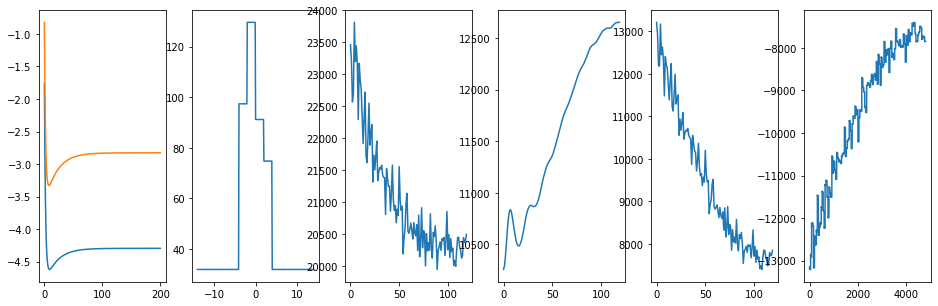

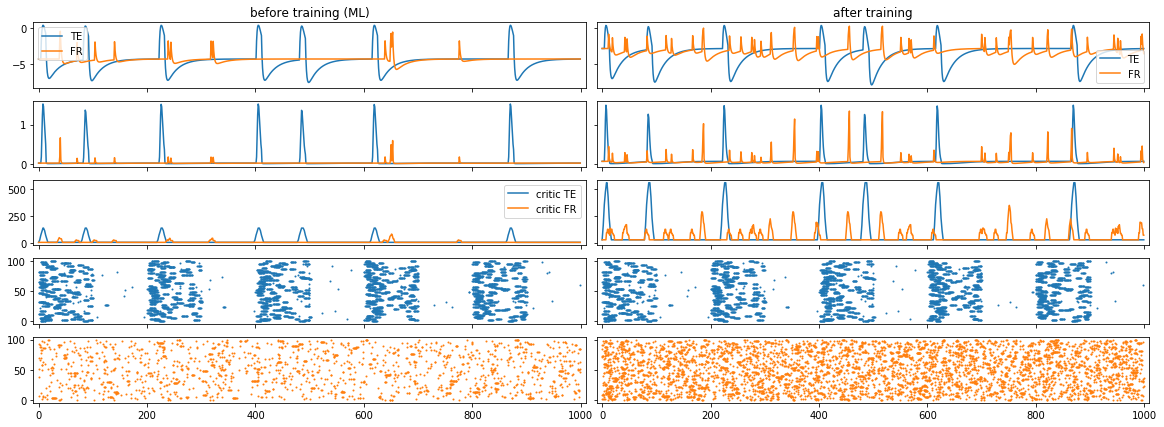

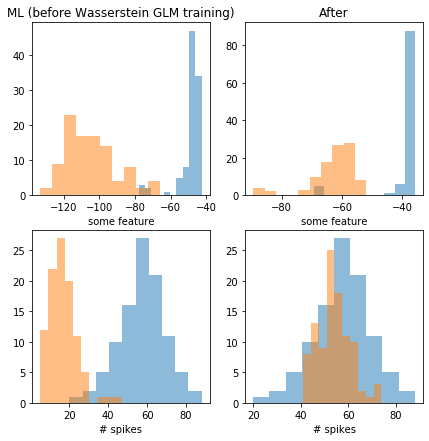

In [10]:
eta_ml = KernelFun.exponential(tau=np.array([2, 20]), coefs=eta_vals_ml.copy())

# critic = CriticPyTorch(r_kernel=r_kernel.copy(), theta=theta.clone(), clip=10e1)
# critic.get_conv_r_spikes(t, mask_spikes)
wglm = WGLM(u0=float(u0_ml), eta=eta_ml.copy(), critic=critic)
# wglm = WGLM(u0=4, eta=eta_ml.copy(), critic=critic)

critic.get_conv_r_spikes(t, mask_spikes_te)
loss, w_distance, neg_w_distance = wglm.train(t, mask_spikes_te, y, lam_w=lam_w, lr_g=lr_g, lr_c=lr_c, num_epochs=num_epochs, 
                                              num_epochs_c=40, n_batch_fr=n_batch_fr, verbose=True)
loss, w_distance, neg_w_distance = np.array(loss), np.array(w_distance), np.array(neg_w_distance)

u_new_fr, r_new_fr, mask_spikes_new_fr = wglm.sample(t, shape=(n_batch_fr,))
u_new_te, r_new_te = wglm.simulate_subthreshold(t, np.zeros(mask_spikes_te.shape), mask_spikes_te)

mask_spikes_new = np.concatenate((mask_spikes_te, mask_spikes_new_fr), axis=1)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)
mask_spikes_new = torch.from_numpy(mask_spikes_new)
u_new = torch.from_numpy(np.concatenate((u_new_te, u_new_fr), axis=1))
r_new = np.concatenate((r_new_te, r_new_fr), axis=1)
r_new = torch.from_numpy(r_new)

# critic_conv_new = critic.r_kernel.convolve_continuous(t, shift_array(mask_spikes, 1, fill_value=False))
critic.get_conv_r_spikes(t, mask_spikes_new)
critic_conv_new = torch.einsum('tka,a->tk', critic.X_r_spk, critic.theta[0:critic.X_r_spk.shape[2]]).detach().numpy()
critic_conv_new_te = critic_conv_new[:, :n_batch_te]
critic_conv_new_fr = critic_conv_new[:, n_batch_te:]

a_new = critic.transform(t, mask_spikes_new, u_new, r_new)
a_new_te = a_new[:n_batch_te]
a_new_fr = a_new[n_batch_te:]

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(16, 5), ncols=6)
ti = np.arange(wglm.eta.support[0], wglm.eta.support[1], .1)
vals_ml = -eta_ml.interpolate(ti) - u0_ml
vals = -wglm.eta.interpolate(ti) - wglm.u0
ax0.plot(ti, vals_ml)
ax0.plot(ti, vals)
ti = np.arange(tbins[0] - 10, tbins[-1] + 10, .1)
vals = critic.r_kernel.interpolate(ti) + critic.theta.detach().numpy().data[0]
ax1.plot(ti, vals)
ax2.plot(loss)
ax3.plot(loss - w_distance)
ax4.plot(w_distance)
ax5.plot(neg_w_distance)

fig, ((ax00, ax01), (ax10, ax11), (ax20, ax21), (ax30, ax31), (ax40, ax41)) = plt.subplots(figsize=(20, 7), nrows=5, ncols=2, 
                                                                                           sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.02)

ax00.set_title('before training (ML)')
ax00.plot(t, u_te[:, 0], label='TE')
ax00.plot(t, u_fr[:, 0], label='FR')
ax00.legend()
ax10.plot(t, r_te[:, 0])
ax10.plot(t, r_fr[:, 0])
ax20.plot(t, critic_conv_te[:, 0], label='critic TE')
ax20.plot(t, critic_conv_fr[:, 0], label='critic FR')
# ax20.plot(t, (critic_conv_te * r_te)[:, 0])
# ax20.plot((critic_conv_fr * r_fr)[:, 0])
ax20.legend()
SpikeTrain(t, mask_spikes_te.numpy()).plot(ax=ax30, ms=ms, color='C0')
SpikeTrain(t, mask_spikes_fr).plot(ax=ax40, ms=ms, color='C1')

ax01.set_title('after training')
ax01.plot(t, u_new_te[:, 0], label='TE')
ax01.plot(t, u_new_fr[:, 0], label='FR')
ax01.legend()
ax11.plot(t, r_new_te[:, 0])
ax11.plot(t, r_new_fr[:, 0])
ax21.plot(t, critic_conv_new_te[:, 0], label='critic TE')
ax21.plot(t, critic_conv_new_fr[:, 0], label='critic FR')
# ax21.plot(t, (critic_conv_te * r_te)[:, 0])
# ax21.plot((critic_conv_fr * r_fr)[:, 0])
SpikeTrain(t, mask_spikes_te.numpy()).plot(ax=ax31, ms=ms, color='C0')
SpikeTrain(t, mask_spikes_new_fr).plot(ax=ax41, ms=ms, color='C1')
fig.savefig('/home/diego/Dropbox/generative_glm/example11.pdf')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax1.hist(a_te.detach().numpy(), alpha=0.5)
ax1.hist(a_fr.detach().numpy(), alpha=0.5)
ax2.hist(a_new_te.detach().numpy(), alpha=0.5)
ax2.hist(a_new_fr.detach().numpy(), alpha=0.5)

ax3.hist(n_spikes_te, alpha=0.5)
ax3.hist(n_spikes_fr, alpha=0.5)
ax4.hist(n_spikes_te, alpha=0.5)
ax4.hist(n_spikes_new_fr, alpha=0.5)

ax1.set_title('ML (before Wasserstein GLM training)')
ax2.set_title('After')
ax1.set_xlabel('some feature')
ax2.set_xlabel('some feature')
ax3.set_xlabel('# spikes')
ax4.set_xlabel('# spikes')

fig.savefig('/home/diego/Dropbox/generative_glm/example12.pdf')

In [12]:
1153 - 827

326

In [ ]:
a_new_fr

In [52]:
u, r2 = wglm.simulate_subthreshold(t, np.zeros(mask_spikes_new_fr.shape), mask_spikes_new_fr)
a2 = critic.transform(t, mask_spikes_new_fr, r2)

fig, ax = plt.subplots()
ax.hist(a_fr.detach().numpy(), alpha=0.5)
ax.hist(a_new_fr.detach().numpy(), alpha=0.5)
ax.hist(a2.detach().numpy(), alpha=0.5)

ValueError: operands could not be broadcast together with shapes (1000,200) (1000,100) 

In [ ]:
eta_ml = KernelFun.exponential(tau=np.array([2, 20]), coefs=eta_vals_ml.copy())

wglm = WGLM(u0=u0_ml, eta=eta_ml.copy(), critic=critic.copy())

newton_kwargs_critic = dict(max_iterations=20, learning_rate=1e0, use_hessian=False, warm_up_iterations=3, 
                            clip_theta=clip_theta, stop_cond=1e-8)
newton_kwargs = dict(max_iterations=40, learning_rate=1e-1, use_hessian=True, stop_cond=1e-12)
optimizer = wglm.fit(t, mask_spikes, newton_kwargs=newton_kwargs, verbose=True, n_samples_fr=200,
            newton_kwargs_critic=newton_kwargs_critic)

stim_naive = np.zeros((len(t), 200))


fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 4), ncols=5)
# eta_ml.plot(ax=ax0, invert_values=True)
# wglm.eta.plot(ax=ax0, invert_values=True)
t_ = np.arange(eta_ml.support[0], eta_ml.support[1], .1)
a = -eta_ml.interpolate(t_) - u0_ml
b = -wglm.eta.interpolate(t_) - wglm.u0
ax0.plot(t_, a)
ax0.plot(t_, b)
ax1.plot(optimizer.obj_iterations)
ax2.plot(optimizer.obj_iterations - optimizer.metrics_iterations['c_w_distance'])
# ax3.plot(optimizer.metrics_iterations['c_w_distance'])
ax3.plot(optimizer.metrics_iterations['w_distance'])
ax4.plot(np.concatenate((optimizer.metrics_iterations['w_distance2'])))

ax1.set_title('objective')
ax2.set_title('log-likelihood')
ax3.set_title('wasserstein distance')
ax4.set_title('wasserstein distance')

if wglm.critic.u_kernel is not None:
    fig, (ax0, ax1) = plt.subplots(figsize=(16, 5), ncols=2)
    wglm.critic.u_kernel.plot(ax=ax0, invert_values=True)

In [ ]:
a = critic.transform(t, mask_spikes, u, r, u0=u0_ml)
a_new_te = wglm.critic.transform(t, mask_spikes_te, u_new_te, r_new_te, u0=wglm.u0)
a_new_fr = wglm.critic.transform(t, mask_spikes_fr, u_new_fr, r_new_fr, u0=wglm.u0)
# a = a - np.mean(a[y == 0])
# a_new_te = a_new_te - np.mean(a_new_fr)
# a_new_fr = a_new_fr - np.mean(a_new_fr)

n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), nrows=2)
ax1.plot(u_new_te[:, 0])
ax1.plot(u_new_fr[:, 0])
ax2.plot(r_new_te[:, 0])
ax2.plot(r_new_fr[:, 0])
# ax.plot(mask_spikes_te[:, 0])



In [ ]:
fig, ax = plt.subplots()
z = np.random.rand(100)
ax.plot(np.zeros(len(z)), z, 'o', ms=1)
ax.plot(np.ones(len(z)), z, 'o', ms=1)
ax.set_xlim(-1, 2)
ax.set_xticks([0, 1])
# ax.set_xticklabels([0, '$\theta$'])
ax.set_xticklabels([0, r"$\theta$"])